In [1]:
import jax
import jax.numpy as jnp

x = jnp.arange(10)
print(x)

[0 1 2 3 4 5 6 7 8 9]


In [2]:
long_vector = jnp.arange(int(1e7))

%timeit jnp.dot(long_vector, long_vector).block_until_ready()

107 µs ± 771 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [3]:
import numpy as np

long_vector = np.arange(int(1e7))

%timeit np.dot(long_vector, long_vector)

6.57 ms ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
def sum_of_squares(x):
  return jnp.sum(x**2)

In [5]:
sum_of_squares_dx = jax.grad(sum_of_squares)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])

print(sum_of_squares(x))

print(sum_of_squares_dx(x))

30.0
[2. 4. 6. 8.]


In [6]:
def sum_squared_error(x, y):
  return jnp.sum((x-y)**2)

sum_squared_error_dx = jax.grad(sum_squared_error)

y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

print(sum_squared_error_dx(x, y))

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]


In [7]:
jax.grad(sum_squared_error, argnums=(0, 1))(x, y)  # Find gradient wrt both x & y

(Array([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 Array([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32))

In [8]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [9]:
jax.value_and_grad(sum_squared_error)(x, y)

(Array(0.03999995, dtype=float32),
 Array([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32))

In [11]:
def squared_error_with_aux(x, y):
  return sum_squared_error(x, y), x-y

jax.grad(squared_error_with_aux)(x, y)

TypeError: Gradient only defined for scalar-output functions. Output was (Array(0.03999995, dtype=float32), Array([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32)).

In [12]:
jax.grad(squared_error_with_aux, has_aux=True)(x, y)

(Array([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 Array([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32))

In [13]:
import numpy as np

x = np.array([1, 2, 3])

def in_place_modify(x):
  x[0] = 123
  return None

in_place_modify(x)
x

array([123,   2,   3])

In [14]:
in_place_modify(jnp.array(x))  # Raises error when we cast input to jnp.ndarray

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [15]:
def jax_in_place_modify(x):
  return x.at[0].set(123)

y = jnp.array([1, 2, 3])
jax_in_place_modify(y)

Array([123,   2,   3], dtype=int32)

In [16]:
y

Array([1, 2, 3], dtype=int32)

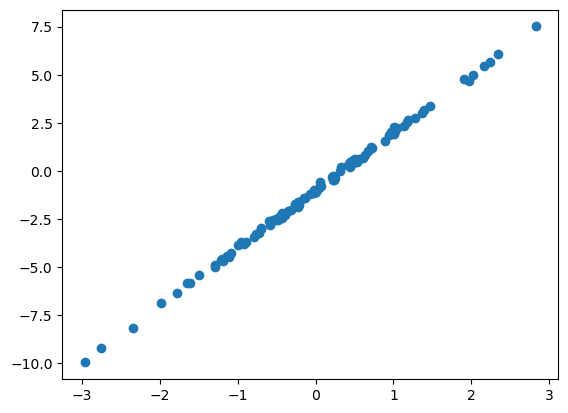

In [17]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

In [18]:
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

In [19]:
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

In [20]:
def update(theta, x, y, lr=0.1):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

w: 3.00, b: -1.00


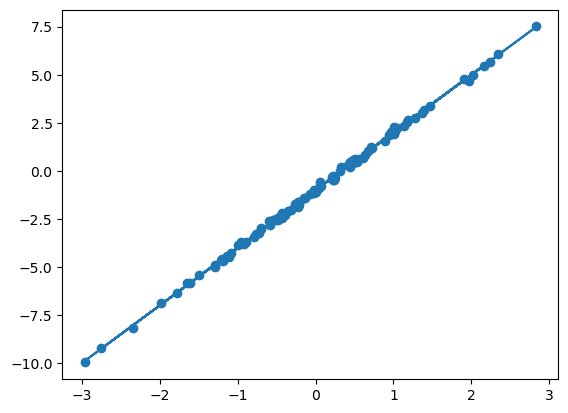

In [21]:
theta = jnp.array([1., 1.])

for _ in range(1000):
  theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

In [22]:
import jax
import jax.numpy as jnp

global_list = []

def log2(x):
  global_list.append(x)
  ln_x = jnp.log(x)
  ln_2 = jnp.log(2.0)
  return ln_x / ln_2

print(jax.make_jaxpr(log2)(3.0))

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }


In [23]:
print(global_list)

[Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>]


In [24]:
jax.make_jaxpr(log2)(3.0)

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }

In [25]:
global_list

[Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>,
 Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>]

In [26]:
func = jax.make_jaxpr(log2)

In [27]:
func(3.0)

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }

In [28]:
global_list

[Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>,
 Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>,
 Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>]

In [29]:
func(3.0)
global_list

[Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>,
 Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>,
 Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>,
 Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>]